In [10]:
import os
from os.path import isfile, join
from os import walk
from pathlib import Path
import json
import pandas as pd
from tqdm import tqdm
from sigmf import SigMFFile, sigmffile
from matplotlib import cbook
from matplotlib import cm
from matplotlib.colors import LightSource
import matplotlib.pyplot as plt
#from mpl_toolkits.mplot3d import axes3d
import numpy as np
import scipy
import tarfile

class analysis():
    def __init__(self, _dir_path = 'full_dataset/',
                 _threshold_file = '',
                 _licenses_json = 'spectrumMapping.json',
                 _upper_lim = 2024*1e6,
                 _lower_lim = 0,
                 _data_length = 16384,
                _line_fit_order = 12,
                _threshold_offset = 5,
                _samples_to_average = 24*7):
        
        self.dir_path = _dir_path
        self.filepaths = [] #list of paths to files.
        self.threshold_file = _threshold_file
        self.data_length = _data_length
        self.f_axis = np.linspace(_lower_lim, _upper_lim, num = _data_length)
        self.line_fit_order = _line_fit_order
        self.threshold_offset = _threshold_offset
        self.samples_to_average = _samples_to_average
        self.data = np.zeros(_data_length)
        self.threshold = np.zeros(_data_length)
        self.bin_data = np.zeros(_data_length)
        # datasets
        self.raw_dataset = np.zeros((1,self.data_length))
        self.bin_dataset = np.zeros((1,self.data_length))
        self.lower_lim = _lower_lim
        self.upper_lim = _upper_lim
        self.samples = 0
        
        # data reduction
        self.allocated_spectrum = json.load(open(_licenses_json))
        self.f_axis_filtered = []
        self.idx_filtered = []
        # black list
        self.s_blist = []
        self.u_blist = []
        # lookup list. 
        self.s_llist = []
        self.u_llist = []
        
        
    def set_blacklist(self, s, u):
        self.s_blist = s
        self.u_blist = u
        
    def set_lookuplist(self, s, u):
        self.s_llist = s
        self.u_llist = u
        
        
    ############################# Processing Methods ###########################
    # methods to load dataset, decimate, binatise, filter out blacklist or 
    # lookup specific service / services
    
    def filter_f_axis(self):
        print("filtering out blacklisted and or looking up services.")
        self.f_axis_filtered = []
        self.idx_filtered = []
        for j in tqdm(range(0,self.data_length)):
            for i in self.allocated_spectrum['bands']:
                if((i["v"] == 1) & (i["lf"] < 2024*1e6)):
                    if((self.u_llist != []) | (self.s_llist != [])):
                        if(((i["u"] in self.u_llist) | (i["s"] in self.s_llist)) & (i["u"] not in self.u_blist) & (i["s"] not in self.s_blist)):
                            if((self.f_axis[j] > i["lf"]) & (self.f_axis[j] < i["uf"])):
                                self.f_axis_filtered.append(self.f_axis[j])
                                self.idx_filtered.append(j)
                                break
                    else:
                        if((i["u"] not in self.u_blist) & (i["s"] not in self.s_blist)):
                            if((self.f_axis[j] > i["lf"]) & (self.f_axis[j] < i["uf"])):
                                self.f_axis_filtered.append(self.f_axis[j])
                                self.idx_filtered.append(j)
                                break
        print("filtered f axis len: "+str(len(self.f_axis_filtered))+ ", removed: "+str(len(self.f_axis)-len(self.f_axis_filtered)))

    def getSigmfData(self,filename):
        signal = sigmffile.fromfile(filename)

        # Get some metadata and all annotations
        sample_rate = signal.get_global_field(SigMFFile.SAMPLE_RATE_KEY)
        annotations = signal.get_annotations()

        for adx, annotation in enumerate(annotations):
            annotation_start_idx = annotation[SigMFFile.START_INDEX_KEY]
            annotation_length = annotation[SigMFFile.LENGTH_INDEX_KEY]
            annotation_comment = annotation.get(SigMFFile.COMMENT_KEY, "[annotation {}]".format(adx))

            # Get capture info associated with the start of annotation
            capture = signal.get_capture_info(annotation_start_idx)
            freq_center = capture.get(SigMFFile.FREQUENCY_KEY, 0)

            # Get frequency edges of annotation (default to edges of capture)
            freq_start = annotation.get(SigMFFile.FLO_KEY)
            freq_stop = annotation.get(SigMFFile.FHI_KEY)

            # Get the samples corresponding to annotation
            samples = signal.read_samples(annotation_start_idx, annotation_length)


            dict = { b'lower_lim': freq_start, b'upper_lim': freq_stop ,b'samples': annotation_length,b'data': samples}
        return dict        
    
    def setSigmfData(self,filename):
        self.data = self.getSigmfData(filename)
        
        # update variables
        self.dala_length = len(self.data[b'data'])
        self.f_axis = np.linspace(self.data[b'lower_lim'], self.data[b'upper_lim'], num = len(self.data[b'data']))
        #self.threshold = np.zeros(self.dala_length)
        self.bin_data = np.zeros(self.dala_length)
    
    def get_threshold(self, offset = 5):
        self.threshold_offset = offset
        spectrumDict = self.getSigmfData(self.filepaths[0])
        data = np.zeros(len(spectrumDict[b'data']))
        count = 1
        for file in self.filepaths:
            spectrumDict = self.getSigmfData(file)
            data = np.add(data,spectrumDict[b'data'])
            count += 1
            spectrumDict[b'data'] = data
            if(count>self.samples_to_average):
                break
                
        spectrumDict[b'data'] = spectrumDict[b'data']/count
        df = pd.DataFrame({'data': spectrumDict[b'data']})
        freq_axis = self.f_axis
        ema = df.ewm(span=10).mean()
        coeff = np.polyfit(freq_axis,ema['data'], self.line_fit_order)
        p = np.poly1d(coeff) # 12 is good
        fit = p(freq_axis)+self.threshold_offset
        self.threshold = fit
        #return fit

    def binarize(self, data = []):
        if len(data) == 0:
            data = self.data[b'data']
        bitdata = self.bin_data
        for i in range(0,self.data_length):
            if(data[i] > self.threshold[i]):
                bitdata[i] = 1
            else:
                bitdata[i] = 0
        return bitdata
    
    def decimate_dataset(self,dec_to = 4096, mode = 'none'):
        k = int(len(self.raw_dataset[1,:])/dec_to)
        L = len(self.raw_dataset[:,1])-1
        S = len(self.raw_dataset[1,:])
        print("L: "+ str(L))
        print("k: "+ str(k))
        if mode == 'max':
            self.raw_dataset = np.array([np.maximum.reduceat(self.raw_dataset[i,:], np.arange(0,S,k)) for i in range(0,L)])
            self.threshold = np.maximum.reduceat(self.threshold, np.arange(0,len(self.threshold),k))
        else:
            self.raw_dataset = scipy.signal.decimate(self.raw_dataset,k,axis = 1)
            self.threshold = scipy.signal.decimate(self.threshold,k,axis = 0)
            
        self.f_axis = np.linspace(self.lower_lim, self.upper_lim, num = len(self.raw_dataset))
        print("decimated dataset shape:"+str(self.raw_dataset.shape))
        
    def get_dataset(self):
        print("loading raw dataset..")
        data = np.zeros((1,self.data_length))
        for file in tqdm(self.filepaths):
            data = self.getSigmfData(file)
            self.raw_dataset = np.concatenate((self.raw_dataset,[data[b'data']]),axis=0)
        self.raw_dataset = self.raw_dataset[1:,:]
        
        self.samples = len(self.raw_dataset[:,1])
        print("complete. data shape: " +str(self.raw_dataset.shape))
        
    def binarize_dataset(self):
        print("Binarizing dataset..")
        for i in tqdm(range(0,len(self.raw_dataset[:,1]))):
            data =  self.binarize(self.raw_dataset[i,:])
            self.bin_dataset = np.concatenate((self.bin_dataset,[data]),axis=0)
        self.bin_dataset = self.bin_dataset[1:,:]
        print("complete. data shape: " +str(self.bin_dataset.shape))
        
        
        
    ####################################### PLOTS ######################################
    # Methods to plot the dataset or part of it in various ways.
    # definition of mode = 'qt' will generate the plot externally.
    # default is 'inline'.
        
    def plot_f_axis(self, mode = 'inline'):
        %matplotlib inline
        f_bitdata = np.zeros(len(self.f_axis))
        
        for i in range(0,len(f_bitdata)):
            if i in self.idx_filtered:
                f_bitdata[i] = 1
        
        if mode == 'qt':
            %matplotlib qt
        else:
            %matplotlib inline
            
        fig = plt.figure()
        plt.plot(self.f_axis,f_bitdata) #
        plt.xlabel('frequency')
        plt.ylabel('binary on / off')
        plt.title("Selective frequencies")
    
    
    def plot_test_file(self, mode = 'inline', idx = -1):
        
        if idx == -1:
            self.binarize()
            data = self.data[b'data']
            bin_data = self.bin_data
        else:
            data = self.raw_dataset[idx,:]
            bin_data = self.binarize(self.raw_dataset[idx,:])
        
        if mode == 'qt':
            %matplotlib qt
        else:
            %matplotlib inline
            
        fig = plt.figure()
        fig, ax = plt.subplots()
        ax.plot(self.f_axis,data, label='Spectrum')
        ax.plot(self.f_axis,self.threshold, label='thresh')
        ax.plot(self.f_axis,bin_data, label='binary data')
        ax.set_xlabel('frequency')
        ax.set_ylabel('binary on / off')
        ax.set_title("My Plot")
        ax.legend()
        
        
    def plot_f_time(self,findex = 0, ssample = 0, esample = 1, mode = 'inline', processing = 'none', span = 10):
        if processing == 'ewm':
            df = pd.DataFrame({'data': self.raw_dataset[:,findex]})
            data = df.ewm(span=span).mean()
        else:
            data = self.raw_dataset[:,findex]
        
        
        if mode == 'qt':
            %matplotlib qt
        else:
            %matplotlib inline
            
        fig = plt.figure()
        plt.plot(np.arange(ssample,esample,1),data[ssample:esample])
        plt.xlabel('samples time [hrs]')
        plt.ylabel('Magnitude')
        plt.title("Observed frequency : "+str(self.f_axis[findex]/1e6)+" MHz")
    
    def plot_dataset(self, processing = 'none',mode = 'inline'):
        data = []
        if mode == 'qt':
            %matplotlib qt
        else:
            %matplotlib inline
        
        if(processing == 'binarized'):
            if len(self.idx_filtered) != 0:
                data = np.transpose([self.bin_dataset[:,i] for i in self.idx_filtered])
                print("showing services:"+ str(self.s_llist))
                print("showing users   :"+ str(self.u_llist))
            else:
                data = self.bin_dataset
        else:
            if len(self.idx_filtered) != 0:
                data = np.transpose([self.raw_dataset[1:,i] for i in self.idx_filtered])
                print("showing services:"+ str(self.s_llist))
                print("showing users   :"+ str(self.u_llist))
            else:
                data = self.raw_dataset[1:]
            
            
        fig = plt.figure(figsize=(11, 2))

        ax = fig.add_subplot(111)
        ax.set_title('colorMap')
        plt.imshow(data)
        #ax.set_aspect('equal')

        cax = fig.add_axes([0, 1, 0, 1])
        cax.get_xaxis().set_visible(False)
        cax.get_yaxis().set_visible(False)
        cax.patch.set_alpha(0)
        cax.set_frame_on(False)
        plt.colorbar(orientation='vertical')
        plt.show()
        
        
    def plot3D(self, dec_to= 256, ssample = 0, esample = 23, mode = 'inline'):
        k = int(len(self.raw_dataset[1,:])/dec_to)
        data = scipy.signal.decimate(self.raw_dataset,k,axis = 1)
        z = data[ssample:esample,:]
        
        print("data shape to plot = "+str(data.shape))
        nrows, ncols = z.shape
        x = np.linspace(self.lower_lim, self.upper_lim, ncols)
        y = np.linspace(ssample, esample, nrows)
        x, y = np.meshgrid(x, y)

        if mode == 'qt':
            %matplotlib qt
        else:
            %matplotlib inline

        fig, ax = plt.subplots(subplot_kw=dict(projection='3d'))
        plt.rcParams['figure.figsize'] = [12, 12]
        plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
        plt.title(" Dataset from samples "+str(ssample)+ " to " +str(esample))
        ls = LightSource(270, 45)

        ax.set_xlabel("Frequency [MHz]")
        ax.set_ylabel("samples [n]")
        ax.set_zlabel("Magnnitude [dBFS]")

        # To use a custom hillshading mode, override the built-in shading and pass
        # in the rgb colors of the shaded surface calculated from "shade".
        rgb = ls.shade(z, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
        
        surf = ax.plot_surface(x, y, z, rstride=1, cstride=1, facecolors=rgb,
                                   linewidth=0, antialiased=False, shade=False)
        plt.show()
        
        
    def plot_binarized_usage(self, mode = 'inline'):
        p = np.sum(self.bin_dataset,axis=0)/len(self.bin_dataset[:,1])
        
        
        if len(self.idx_filtered) != 0:
            data = [p[i] for i in self.idx_filtered]
            f = self.f_axis_filtered
            print("showing services:"+ str(self.s_llist))
            print("showing users   :"+ str(self.u_llist))
        else:
            data = p
            f = self.f_axis
            
        print("overall percentage: "+str(sum(data)/len(data)))
        if mode == 'qt':
            %matplotlib qt
        else:
            %matplotlib inline
        fig = plt.figure()
        plt.plot(f,data) #
        plt.xlabel('frequency')
        plt.ylabel('percentage')
        plt.title("Usage per frequencies")
    
    ######################## Other methods ####################################
    # Methods for saving loading files, unzipping tar files and printing out
    # dataset format.
    
    def unzipTar(self, filename = '', destination = '.'):
        file = tarfile.open(filename)
        # extracting file
        file.extractall(destination)
        file.close()
    
    def get_dataset_files(self, path = ''):
        self.filepaths = []
        if len(path) == 0:
            mypath = self.dir_path
        else:
            mypath = path
            
        total_files = 0
        total_samples = 0
        filenames = [(str(dirpath)+'/'+str(f)) for (dirpath, dirnames, filenames) in os.walk(mypath) for f in filenames]
        total_files = len(filenames)
        for file in filenames:
            if file.endswith(".sigmf-meta"):
                self.filepaths.append(file)
                total_samples += 1
                
        print("statistics:")
        print("dataset file count    : "+ str(total_files))
        print("spectrum samples (hrs): "+ str(total_samples))
        print("days available        : "+ str(total_samples/24))
        print("weeks available       : "+ str(total_samples/(24*7)))
        print("loaded files. (self.filepaths)")
    
    def unpickleFile(self, file_path):
        idx = 0
        res = False
        while(res == False):
            try:
                with open(file_path, 'rb') as fo:
                    dict = pickle.load(fo, encoding='bytes')
                    res = True
            except:
                idx += 1
                if(idx >10):
                    break
                time.sleep(0.001)
                dict = {}
                res =  False
        return res, dict
            
    def pickleFile(self, file_path, data):
        idx = 0
        res = False
        while(res == False):
            try:
                pickle.dump(data, open(file_path, 'wb'))
                res = True
            except:
                idx += 1
                if(idx >10):
                    break
                time.sleep(0.001)
                res = False
        return res
        

In [4]:

an = analysis(_samples_to_average = 24*7)
an.get_dataset_files()

statistics:
dataset file count    : 1684
spectrum samples (hrs): 842
days available        : 35.083333333333336
weeks available       : 5.011904761904762
loaded files. (self.filepaths)


<Figure size 640x480 with 0 Axes>

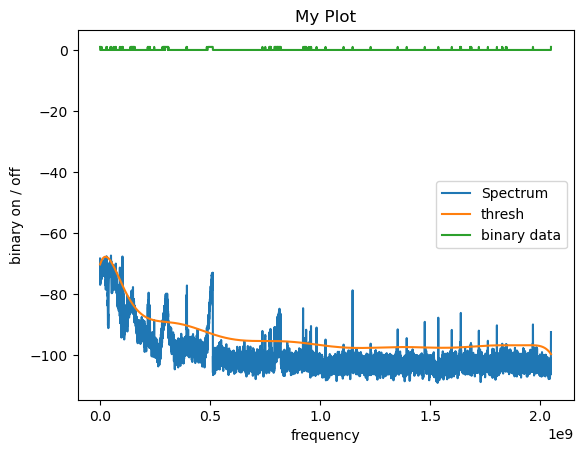

In [8]:
# show frame, threshold and binary.
an.setSigmfData('full_dataset/03/S_01-03-23_22')
an.get_threshold(5)
an.plot_test_file(mode='inline')


statistics:
dataset file count    : 1684
spectrum samples (hrs): 842
days available        : 35.083333333333336
weeks available       : 5.011904761904762
loaded files. (self.filepaths)
loading raw dataset..


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:11<00:00, 74.19it/s]


complete. data shape: (842, 16384)
Binarizing dataset..


100%|████████████████████████████████████████████████████████████████████████████████| 842/842 [00:14<00:00, 59.81it/s]

complete. data shape: (842, 16384)


<Figure size 640x480 with 0 Axes>

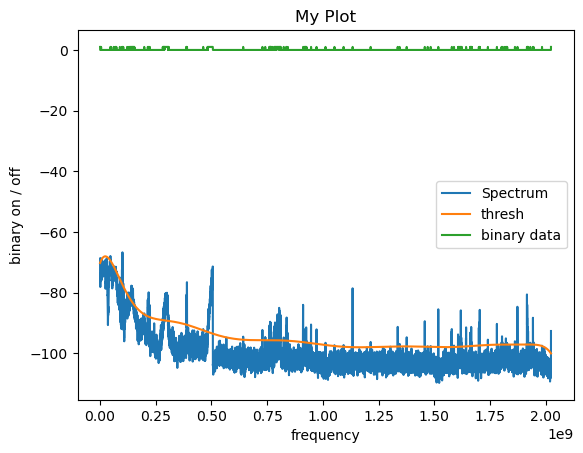

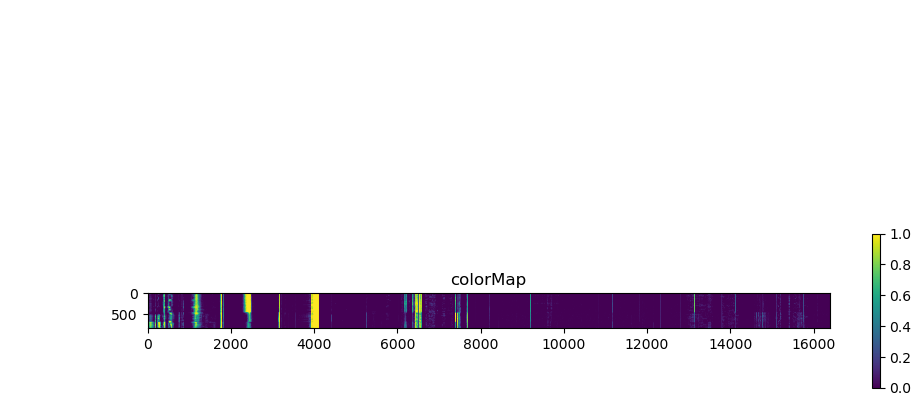

overall percentage: 0.05800724709118407


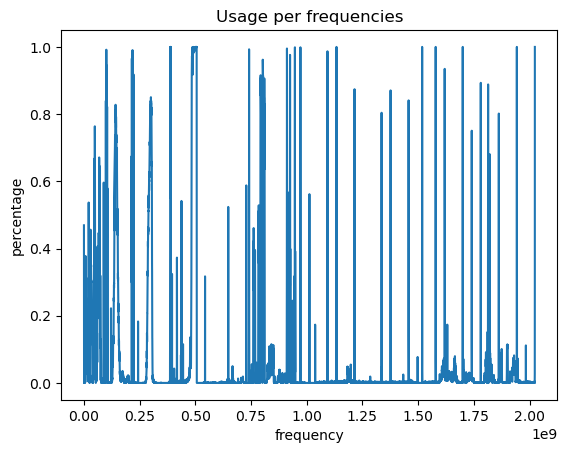

In [13]:
an = analysis(_samples_to_average = 24*14) # use 14 days for threshold generation
an.get_dataset_files()
an.get_dataset()
an.get_threshold(5) # use different threshold and binarize dataset

an.plot_test_file(mode='inline',idx = 55)
an.binarize_dataset()
an.plot_dataset(mode='inline', processing = 'binarized')
an.plot_binarized_usage()

In [ ]:
# define services to filer out using the json file

#s_blist = ['Public sector','Licence exempt','N/A','PMSE']
s_blist = ['Public sector']
u_blist = ['Military']
an.set_blacklist(s_blist,u_blist)
an.set_lookuplist(['Mobile'],[])

an.filter_f_axis() # filters using the loopul list and blacklist to show only required data
an.plot_f_axis(mode = 'inline') # plots the showed frequencies position
an.plot_dataset(mode='inline', processing = 'binarized')
an.plot_binarized_usage()

In [ ]:
an = analysis()
an.get_dataset_files()
an.get_dataset()
an.plot_dataset(mode = 'inline')

In [ ]:
an.plot_f_time(findex = 14512,ssample = 0, esample= 800)
an.plot_f_time(findex = 2250,ssample = 150, esample= 841, processing = 'ewm', span = 12)

In [ ]:
an = analysis()
an.get_dataset_files() # just prints out statistics
an.get_dataset()
an.decimate_dataset(dec_to = 2048, mode = 'max') # max performs maximum operation within the decimation to preserve data
an.plot_dataset(mode='qt')

In [ ]:

an = analysis()
an.get_dataset_files() # just prints out statistics
an.get_dataset()
an.plot3D() # plots 0 to 23 samples 

In [ ]:
# if the dataset is loaded it can be plotted from any sample to any
an.plot3D(mode = 'inline',dec_to = 512, ssample = 500, esample = 510)

In [ ]:
# the analisys class cna unzip tar files 
# specify file path and destination path
# unzip datasets
an = analysis()
an.unzipTar('spectrum_data.tar.gz','full_dataset')
an.unzipTar('spectrum_data_w8.tar.gz','full_dataset')
an.unzipTar('dennistoun_w9.tar.gz','full_dataset')
an.unzipTar('dennistoun_w10.tar.gz','full_dataset')
an.unzipTar('dennistoun_w11.tar.gz','full_dataset')